# PyTorch-Simple-Starter-Using only 21 classes

#### Code copied with minimal changes from this Notebook:
https://www.kaggle.com/code/myso1987/birdclef2022-pytorch-resnet34-starter-lb-0-50

## Library

In [1]:
import os
import json
import tqdm
import random
import shutil
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T
from torchvision.models.resnet import ResNet, BasicBlock

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Data Loading

In [3]:
root_path = "../input/birdclef-2022/"
input_path = root_path + '/train_audio/'
out_path = "./train/"

try:
    os.mkdir(out_path)
except FileExistsError:
    pass


train_meta = pd.read_csv(root_path + 'train_metadata.csv')

with open(root_path + '/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

### only 21 classes

In [4]:
train_meta = train_meta[train_meta['primary_label'].isin(scored_birds)]
bird_label = train_meta["primary_label"].unique()
print(bird_label)

['akiapo' 'aniani' 'apapan' 'barpet' 'crehon' 'elepai' 'ercfra' 'hawama'
 'hawcre' 'hawgoo' 'hawhaw' 'hawpet1' 'houfin' 'iiwi' 'jabwar' 'maupar'
 'omao' 'puaioh' 'skylar' 'warwhe1' 'yefcan']


## Utils

In [5]:
sample_rate = 32000
n_fft = 4096
win_length = None
hop_length = 512
n_mels = 256
min_sec_proc = sample_rate*5
f_min = 250

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    f_min=f_min,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [6]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
    
def normalize_std(spec):
    return (spec- torch.mean(spec))/torch.std(spec)
    
    
def audio_to_mel_label(filepath, min_sec_proc, mode='train', data_index=0, label_list=[], bird_label=[], label_file=[], mel_list=[]):
    if mode == 'train':
        label_file_all = np.zeros(bird_label.shape)
        for label_file_temp in label_file:
            label_file_all += (label_file_temp == bird_label)
        label_file_all = np.clip(label_file_all, 0, 1)
    
    waveform, _ = torchaudio.load(filepath=filepath)
    len_wav = waveform.shape[1]
    waveform = waveform[0,:].reshape(1, len_wav) # stereo->mono mono->mono
    
    if mode == 'train':
        if len_wav < min_sec_proc:
            for _ in range(round(min_sec_proc/len_wav)):
                waveform = torch.cat((waveform,waveform[:,0:len_wav]),1)
            len_wav = min_sec_proc
            waveform = waveform[:,0:len_wav]
            
    elif mode == 'test':
        if not len_wav < min_sec_proc*12:
            waveform = torch.cat((waveform,waveform[:,0:len_wav]),1)
            len_wav = min_sec_proc*12
            waveform = waveform[:,0:len_wav]

    for index in range(int(len_wav/min_sec_proc)):
        log_melspec = torch.log10(mel_spectrogram(waveform[0, index*min_sec_proc:index*min_sec_proc+min_sec_proc]).unsqueeze(0)+1e-10)
        log_melspec = normalize_std(log_melspec)
        
        if mode == 'train':
            torch.save(log_melspec, out_path + str(data_index) + '.pt')
            label_list.append(label_file_all)
            data_index += 1
        elif mode == 'test':
            mel_list.append(log_melspec)
            
    if mode == 'train':
        return data_index
    elif mode == 'test':
        return mel_list
    

def load_tensor(path, file_name):
    return torch.load(path + str(file_name) + '.pt')


def get_X_y(path, idx, label_list):
    batch_X = torch.stack([load_tensor(path, x.item()) for x in idx])
    batch_y = torch.stack([label_list[x.item()] for x in idx])
    return batch_X, batch_y

        
def plor_history(history):
    plt.figure(figsize=(10, 10)) 
    plt.plot(history[:,0], history[:,1], label='loss')
    plt.plot(history[:,0], history[:,2], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    
torch_fix_seed()

## Save melspectrogram

In [7]:
data_index = 0
label_list = []
for pri_label, secon_label, f_name in zip(tqdm.notebook.tqdm(train_meta['primary_label']), train_meta['secondary_labels'],train_meta['filename']):
    data_index = audio_to_mel_label(input_path+f_name, min_sec_proc,'train', data_index, label_list, bird_label, [pri_label] + eval(secon_label))

torch.save(np.stack(label_list), out_path + 'label_list.pt')
label_list = torch.from_numpy(np.stack(label_list)).clone()

  0%|          | 0/1266 [00:00<?, ?it/s]

## Model

In [8]:
n_output = len(bird_label)

out_sigmoid = nn.Sigmoid()

class ResNetBird(ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3], num_classes=n_output)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

        
net = ResNetBird().to(device)

## Data split

In [9]:
train_idx = np.arange(0, label_list.shape[0])

data_len = train_idx.shape[0]
train_idx, val_idx = torch.utils.data.random_split(train_idx, [int(data_len*0.8), data_len-int(data_len*0.8)])

## Train loop

Epoch [1/50], loss: 0.12377, val_loss: 0.10457
Epoch [2/50], loss: 0.09505, val_loss: 0.10049
Epoch [3/50], loss: 0.08393, val_loss: 0.08640
Epoch [4/50], loss: 0.07597, val_loss: 0.08026
Epoch [5/50], loss: 0.06814, val_loss: 0.10397
Epoch [6/50], loss: 0.06102, val_loss: 0.05889
Epoch [7/50], loss: 0.05340, val_loss: 0.06450
Epoch [8/50], loss: 0.04741, val_loss: 0.06832
Epoch [9/50], loss: 0.04196, val_loss: 0.04705
Epoch [10/50], loss: 0.03794, val_loss: 0.05731
Epoch [11/50], loss: 0.03226, val_loss: 0.04646
Epoch [12/50], loss: 0.02868, val_loss: 0.04603
Epoch [13/50], loss: 0.02560, val_loss: 0.04663
Epoch [14/50], loss: 0.02255, val_loss: 0.05080
Epoch [15/50], loss: 0.01922, val_loss: 0.04042
Epoch [16/50], loss: 0.01558, val_loss: 0.04448
Epoch [17/50], loss: 0.01575, val_loss: 0.03550
Epoch [18/50], loss: 0.01245, val_loss: 0.02980
Epoch [19/50], loss: 0.01000, val_loss: 0.03395
Epoch [20/50], loss: 0.00944, val_loss: 0.02991
Epoch [21/50], loss: 0.00827, val_loss: 0.03209
E

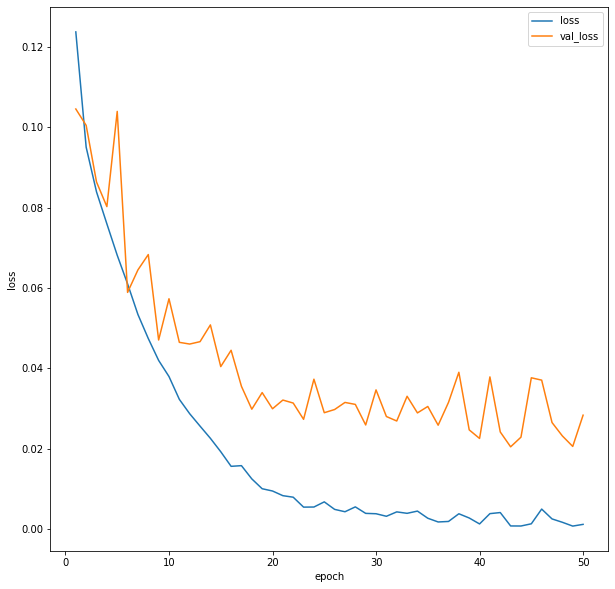

In [10]:
num_epochs = 50
lr = 0.001
batch_size = 32

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 3))

train_loader = DataLoader(train_idx, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_idx, batch_size=batch_size, shuffle=False)


for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    n_train, n_val = 0, 0

    net.train()
    for idx in train_loader:
        inputs, labels = get_X_y(out_path, idx, label_list)
        
        n_train += len(labels)
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    net.eval()
    with torch.no_grad():
        for idx in val_loader:
            inputs_val, labels_val = get_X_y(out_path, idx, label_list)
            n_val += len(labels)

            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)

            outputs_val = net(inputs_val)

            loss_val = criterion(outputs_val, labels_val)

            val_loss += loss_val.item()
    

    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val
    print (f'Epoch [{(epoch+1)}/{num_epochs}], loss: {train_loss:.5f}, val_loss: {val_loss:.5f}')
    item = np.array([epoch+1, train_loss, val_loss])
    history = np.vstack((history, item))

torch.save(net.state_dict(), 'model.pt')
plor_history(history)

## Inference

In [11]:
test_audio_dir = '../input/birdclef-2022/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

print('Number of test soundscapes:', len(file_list))

Number of test soundscapes: 1


In [12]:
pred = {'row_id': [], 'target': []}
binary_th = 0.30
net.eval()

for afile in file_list:
    
    path = test_audio_dir + afile + '.ogg'
    
    chunks = [[] for i in range(12)]
    
    mel_list_test = []
    mel_list_test = audio_to_mel_label(path, min_sec_proc,'test', mel_list=mel_list_test)
    mel_list_test = torch.stack(mel_list_test).to(device)
    
    outputs = net(mel_list_test)
    
    outputs_test = out_sigmoid(outputs)
    
    for idx, i in enumerate(range(len(chunks))):        
        chunk_end_time = (i + 1) * 5
        for bird in scored_birds:
            
            try:
                score = outputs_test[idx][np.where(bird_label==bird)]
            except IndexError:
                score = 0
            
            row_id = afile + '_' + bird + '_' + str(chunk_end_time)
            
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > binary_th else False)

## Submission

In [13]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])

print(results['target']) 
    
results.to_csv("submission.csv", index=False)    

0      False
1      False
2      False
3      False
4      False
       ...  
247    False
248    False
249    False
250    False
251    False
Name: target, Length: 252, dtype: bool


In [14]:
OUTPUT_DATA_DELETE = True

if OUTPUT_DATA_DELETE == True:
    shutil.rmtree(out_path)
    os.remove('model.pt')

## References
[BirdCLEF2022:PyTorch-ResNet34-Starter](https://www.kaggle.com/code/myso1987/birdclef2022-pytorch-resnet34-starter-lb-0-50)

[How to submit to BirdCLEF 2022](https://www.kaggle.com/stefankahl/how-to-submit-to-birdclef-2022)